# 3ML with Fermi GBM TTE Data
### Purpose
Fermi GBM data is in a format that does not lend itself to being used with standard software such as XSPEC. However, the **FermiGBMLikeTTE** in **3ML** plugin allows the user to work directly with the TTE data in its native format

**FermiGBMLikeTTE** provides the following functionality
* Reading GBM TTE data
* Proper MLE polynomial background fitting
* Pure counts and light curve plotting

It creates a standard **3ML** Model and therefore can be used like any other plugin *without* using specical tools to create PHA files.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [7]:
%matplotlib inline
%matplotlib notebook
import os
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
from threeML import *



get_available_plugins()

Available plugins:

FermiGBMTTELike for Fermi GBM TTE (all detectors)
SwiftXRTLike for Swift XRT
OGIPLike for All OGIP-compliant instruments
VERITASLike for VERITAS


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir = os.path.join('gbm','bn080916009')

src_selection = "0.-10."


# We start out with a bad background interval to demonstrate a few features

nai3 = FermiGBMTTELike('NAI3',
                         os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0, 100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v07.rsp"),poly_order=-1)

bgo0 = FermiGBMTTELike('BGO0',
                         os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v07.rsp"))

Auto-determined polynomial order: 1





WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-determined polynomial order: 1


Auto-probed noise models:
- observation: poisson
- background: gaussian


You will get a warning about GBM DRMS because they lack the keyword to indicate the first channel of the DRM. It is ok because the normal choice is 1

The TTE class build upon the generic EventList class which can be used to get some information on or selections.

If you are connected to the internet, timing information for other instruments can be obtained:



In [8]:
nai3.peek()

TTE File Info:


Active Count Error                                 92.1028
Active Counts                                        24940
Active Deadtime                                    0.04988
Active Exposure                                    9.95012
Active Polynomial Counts                           12945.1
Active Selections                            [(0.0, 10.0)]
Number of Channels                                     128
Polynomial Order                                         1
Polynomial Selections       [[-10.0, 0.0], [100.0, 200.0]]
Significance                               [71.9349314012]
Total N. Events                                     451128
Unbinned Fit                                          True
dtype: object

Timing Info:


LIGO/GPS seconds since 1980-01-06 UTC (decimal)                  905559179.614
NuSTAR seconds since 2010.0 UTC (decimal)                        -40693634.386
RXTE seconds since 1994.0 UTC (decimal)                          464141567.236
Suzaku seconds since 2000.0 UTC (decimal)                        274839166.614
Swift seconds since 2001.0 UTC (decimal)                         243216768.715
UTC                                                2008-09-16 00:12:45.614 UTC
XMM/Chandra seconds since 1998.0 TT (decimal)                    337911230.798
dtype: object

Fermi MET OBS Start            2.43217e+08
Fermi MET OBS Stop             2.43217e+08
Fermi Trigger Time             2.43217e+08
Fermi UTC OBS Start    2008-09-16T00:12:20
Fermi UTC OBS Stop     2008-09-16T00:17:47
dtype: object

The information from the background fit polynomials is available as a pandas Panel <['coefficients'] and ['error']>

In [4]:
res = nai3.get_background_parameters()

Coefficients


,0,1,2,3
0,2.263211,-0.028303,0.000360,-1.182201e-06
1,7.694190,0.020140,-0.000325,1.093706e-06
2,6.285192,0.002227,-0.000009,8.450607e-08
3,7.860971,0.020646,-0.000447,1.662854e-06
4,8.525811,0.074399,-0.000980,3.098556e-06
5,11.541888,0.010292,-0.000176,4.047522e-07
6,15.345597,0.052455,-0.000838,2.712181e-06
7,19.756207,0.177978,-0.002116,6.295211e-06
8,21.827851,0.157837,-0.001715,4.772313e-06
9,29.162979,0.001347,-0.000194,5.983392e-07


Coefficient Error


,0,1,2,3
0,0.435522,0.014982,0.000178,6.033965e-07
1,0.756114,0.028186,0.000356,1.222335e-06
2,0.696312,0.025712,0.000325,1.124816e-06
3,0.773195,0.027872,0.000342,1.164607e-06
4,0.789230,0.029748,0.000378,1.301868e-06
5,0.951871,0.034769,0.000428,1.463536e-06
6,1.074722,0.039391,0.000490,1.673618e-06
7,1.207958,0.046411,0.000593,2.050078e-06
8,1.271437,0.049162,0.000632,2.185623e-06
9,1.493543,0.054304,0.000676,2.318636e-06


We can set the background polynomial order ourself, or use LRT to decide which order is best. If the order is set to -1, then it is automatically determined. Setting the order will initiate a refit of the background using the last imput background interval selections.

In [6]:
nai3.background_poly_order = 0

Refitting background with new polynomial order and existing selections


Let's look at the lightcurve of NAI3 to check out background fit:

<IPython.core.display.Javascript object>


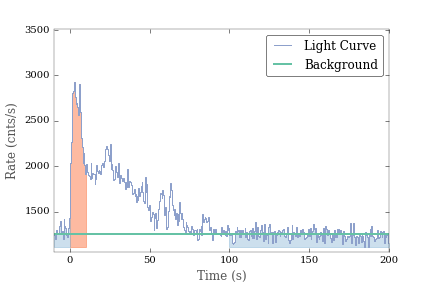

In [7]:
nai3.view_lightcurve(-10,200.,.5)

Oy! That is not so nice! Luckily, we can simply select another interval!

Auto-probed noise models:
- observation: poisson
- background: gaussian
Refitting background with new polynomial order and existing selections
Auto-determined polynomial order: 1




<IPython.core.display.Javascript object>


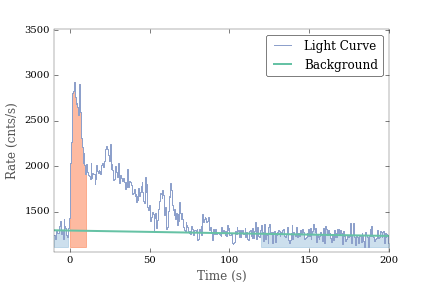

In [8]:
nai3.set_background_interval("-10.--1.","120-200") # You can select as many as required!
nai3.background_poly_order = -1 # Auto determine!
nai3.view_lightcurve(-10,200.,.5)

It is also possible to select multiple (disjoint only) src intervals

Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


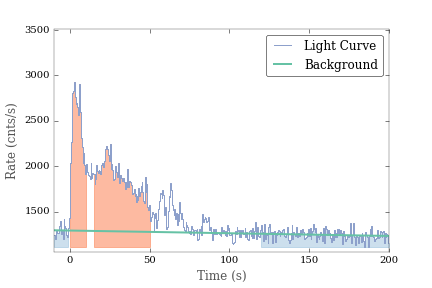

In [9]:
nai3.set_active_time_interval('0-10','15-50')

nai3.view_lightcurve(-10,200.,.5)

Selecting non-disjoint intervals will result in an error:

In [10]:
nai3.set_active_time_interval('0-10','5-50')


OverLappingIntervals: Provided intervals are overlapping and hence invalid

In [6]:
# go back to our original selection
nai3.set_active_time_interval(src_selection)

Auto-probed noise models:
- observation: poisson
- background: gaussian


If we want to examine the light curve in different energy ranges, we can supply an argument:

<IPython.core.display.Javascript object>


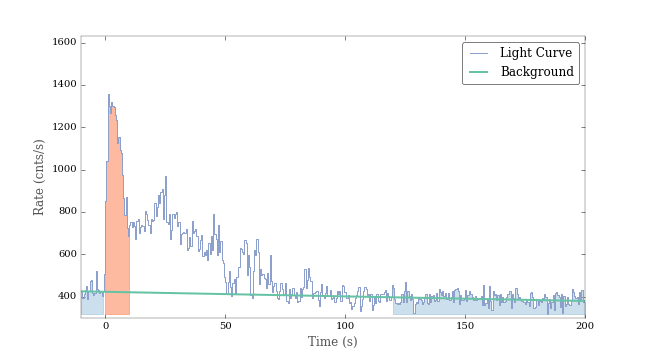

In [12]:
nai3.view_lightcurve(-10,200.,.5,energy_selection='50-300')

<IPython.core.display.Javascript object>


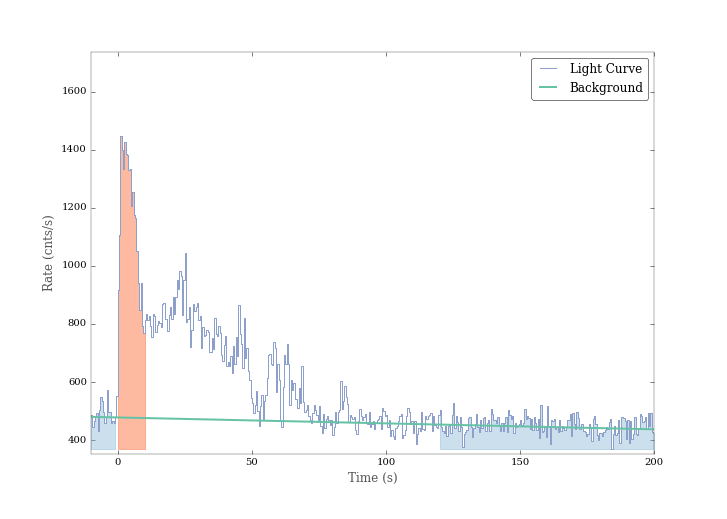

In [13]:

nai3.view_lightcurve(-10,200.,.5,energy_selection='50-300, 500-900')

### Energy selection

We need to select the energies we would like to fit over. GBM has over/underflow channels which must be exlcuded from the fit. This is not always at the same energy, so we need to check.
**FermiGBM_TTE_Like**  (and **FermiGBMLike** ) allow you to plot the count spectra so you can see what you will be excluding in the fit.

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128


<IPython.core.display.Javascript object>


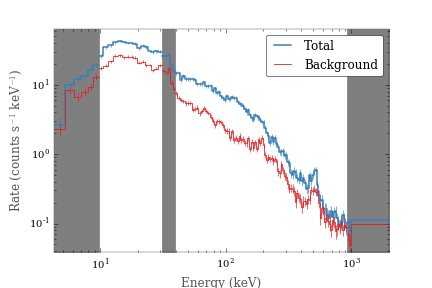

In [5]:
nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai3.view_count_spectrum()

Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


<IPython.core.display.Javascript object>


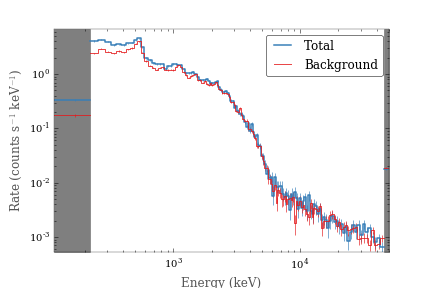

In [6]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

## Fitting!

We are now ready for the standard **3ML** process:


In [7]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

name,value,min_value,max_value,unit,delta,free
bn080916009.spectrum.main.Band.K,0.0001,None,None,1 / (cm2 keV s),1e-05,True
bn080916009.spectrum.main.Band.alpha,-1.0,-1.5,3.0,,0.1,True
bn080916009.spectrum.main.Band.xp,500.0,10.0,None,keV,50.0,True
bn080916009.spectrum.main.Band.beta,-2.0,-5.0,-1.6,,0.2,True


In [8]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn080916009.spectrum.main.Band.K,0.0306 +/- 0.0014,1 / (cm2 keV s)
1,bn080916009.spectrum.main.Band.alpha,-0.95 +/- 0.04,
2,bn080916009.spectrum.main.Band.xp,(7.6 +/- 1.2)e+02,keV
3,bn080916009.spectrum.main.Band.beta,-2.14 +/- 0.11,



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.86,-0.95,0.57
0.86,1.00,-0.89,0.50
-0.95,-0.89,1.00,-0.66
0.57,0.50,-0.66,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,1616.947370
NAI3,762.608194
BGO0,854.339176


We can examine our fit with the data:

<IPython.core.display.Javascript object>


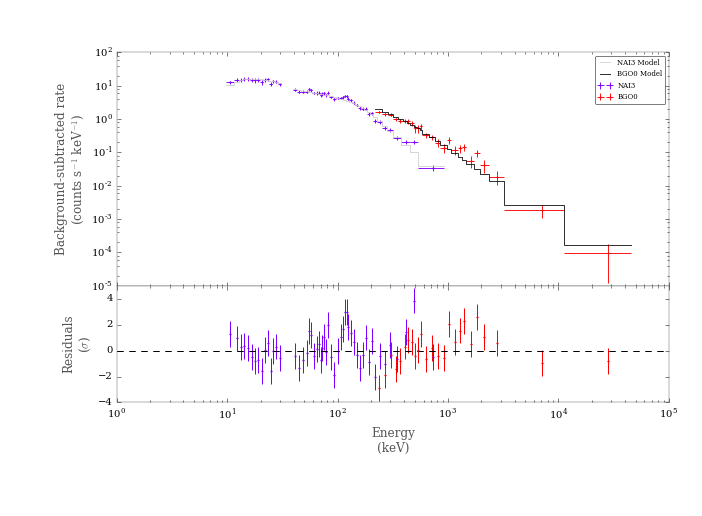

In [9]:
_ = display_ogip_model_counts(jl,min_rate=15)

In [24]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0304 -0.0014 +0.0015,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.97 -0.04 +0.04,
bn080916009.spectrum.main.Band.xp,(7.7 -1.1 +1.4)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.14 -0.14 +0.10,


<IPython.core.display.Javascript object>


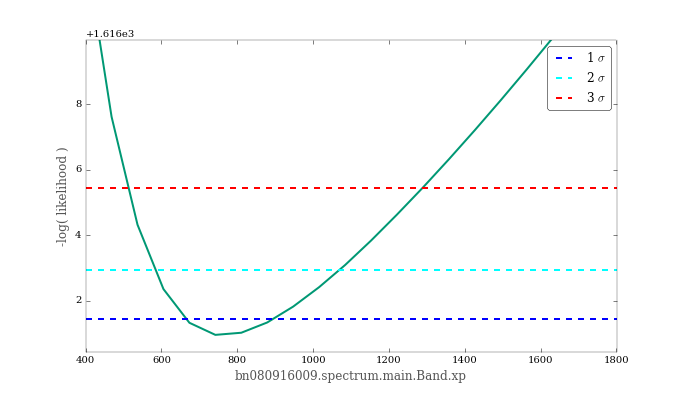

In [13]:
res = jl.get_contours(band.xp,400,1700,20)

<IPython.core.display.Javascript object>


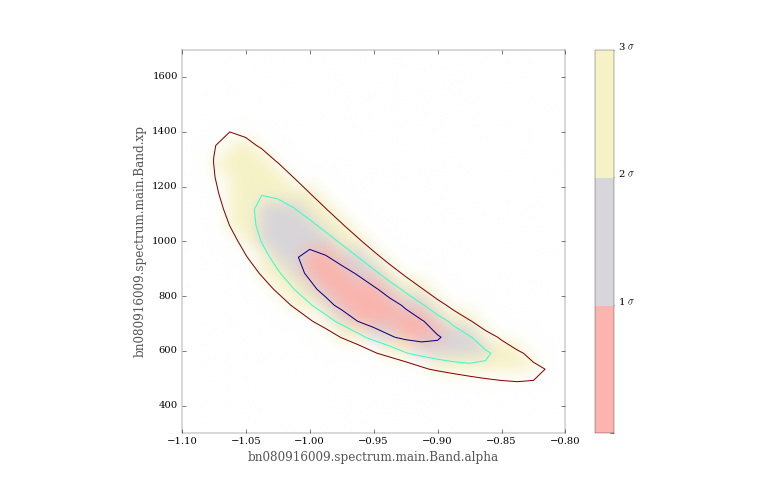

In [14]:
res = jl.get_contours(band.xp,300,1700,25,band.alpha,-1.1,-0.8,25)

## Time-resolved MLE analysis.

We often want to analyze the time resolved properties of a GRB. We can use the eventlist binning capabilities to bin the TTE lightcurve and then analyze these bins all at once.


We will create significance bins using the NaI3 lightcurve.


In [10]:
nai3.create_time_bins(start=0,stop=10,method='significance',sigma=30)

<IPython.core.display.Javascript object>


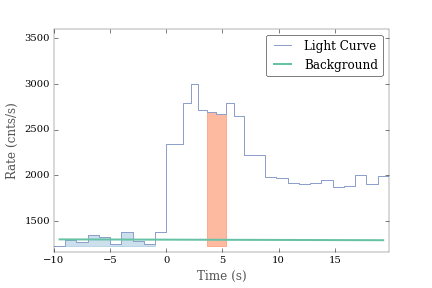

In [26]:
nai3.view_lightcurve(use_binner=True)

Alternatively, we can use Bayesian blocks (Scargle et al. 2013) to define bins. We can even use the background fit to adjust the the over all count rate. 

In [8]:
nai3.create_time_bins(start=0,stop=10,method='bayesblocks',p0=0.1,use_background=False)

<IPython.core.display.Javascript object>


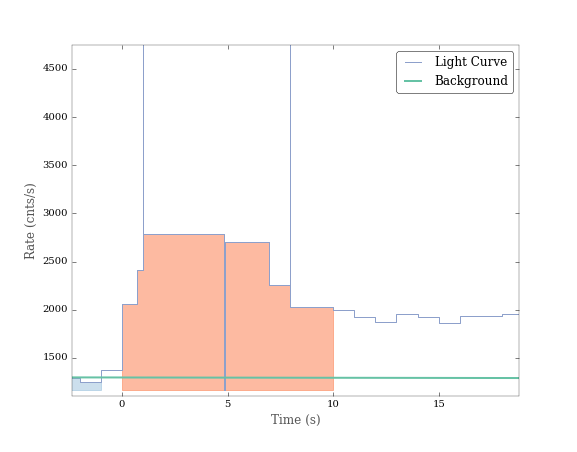

In [9]:
nai3.view_lightcurve(use_binner=True)

We must define functions to get the data and the model for the JointLikelihoodSet. For the TTE data, this means simply seting the bins we want to use.

The easiest way to acheive this is with a binner object and then a iterating through the text_bins list that is generated:


In [21]:
def data_getter(id):
    
    
    new_data = []
    
    for data in data_list.values():
        
        data.set_active_time_interval(nai3.text_bins[id])
        new_data.append(data)
    
    return DataList(*new_data)
    
    
def model_getter(id):
    
    return clone_model(model)   
    
    

Now we simply pass these functions to the JointLikelihoodSet and we can go

In [28]:
jl_set = JointLikelihoodSet(data_getter=data_getter,model_getter=model_getter,n_iterations=len(nai3.text_bins))


res, lh = jl_set.go()


Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



In [29]:
res

value  error
0 bn080916009.spectrum.main.Band.K          0.149628    NaN
  bn080916009.spectrum.main.Band.alpha      0.066388    NaN
  bn080916009.spectrum.main.Band.xp       100.016110    NaN
  bn080916009.spectrum.main.Band.beta      -1.748906    NaN
1 bn080916009.spectrum.main.Band.K          0.023364    NaN
  bn080916009.spectrum.main.Band.alpha     -1.242602    NaN
  bn080916009.spectrum.main.Band.xp      2222.781362    NaN
  bn080916009.spectrum.main.Band.beta      -4.987430    NaN
2 bn080916009.spectrum.main.Band.K          0.027818    NaN
  bn080916009.spectrum.main.Band.alpha     -1.241225    NaN
  bn080916009.spectrum.main.Band.xp      1432.973104    NaN
  bn080916009.spectrum.main.Band.beta      -4.978856    NaN
3 bn080916009.spectrum.main.Band.K          0.023969    NaN
  bn080916009.spectrum.main.Band.alpha     -1.188213    NaN
  bn080916009.spectrum.main.Band.xp      1189.315111    NaN
  bn080916009.spectrum.main.Band.beta      -3.457486    NaN
4 bn080916009.spectrum.main.Band.K          0.022576    NaN
  bn080916009.spectrum.main.Band.alpha     -1.190086    NaN
  bn080916009.spectrum.main.Band.xp      2550.877636    NaN
  bn080916009.spectrum.main.Band.beta      -4.914733    NaN
5 bn080916009.spectrum.main.Band.K          0.020503    NaN
  bn080916009.spectrum.main.Band.alpha     -1.215970    NaN
  bn080916009.spectrum.main.Band.xp      6723.519118    NaN
  bn080916009.spectrum.main.Band.beta      -2.812594    NaN
6 bn080916009.spectrum.main.Band.K          0.020864    NaN
  bn080916009.spectrum.main.Band.alpha     -1.499922    NaN
  bn080916009.spectrum.main.Band.xp     12386.169404    NaN
  bn080916009.spectrum.main.Band.beta      -2.633077    NaN
7 bn080916009.spectrum.main.Band.K          0.031535    NaN
  bn080916009.spectrum.main.Band.alpha     -1.231362    NaN
  bn080916009.spectrum.main.Band.xp       155.905413    NaN
  bn080916009.spectrum.main.Band.beta      -1.700599    NaN
8 bn080916009.spectrum.main.Band.K          0.038473    NaN
  bn080916009.spectrum.main.Band.alpha     -0.888364    NaN
  bn080916009.spectrum.main.Band.xp       107.065934    NaN
  bn080916009.spectrum.main.Band.beta      -1.853850    NaN

In [31]:
lh

-log(likelihood)
0 total       1203.249298
  NAI3         564.851941
  BGO0         638.397357
1 total        866.680167
  NAI3         407.242793
  BGO0         459.437375
2 total        747.695274
  NAI3         350.614322
  BGO0         397.080953
3 total        917.527112
  NAI3         409.225237
  BGO0         508.301874
4 total        923.938335
  NAI3         418.048509
  BGO0         505.889826
5 total        945.850362
  NAI3         422.507660
  BGO0         523.342702
6 total        818.527407
  NAI3         374.260651
  BGO0         444.266756
7 total        890.714499
  NAI3         416.751291
  BGO0         473.963208
8 total       1185.632607
  NAI3         558.381424
  BGO0         627.251183

## And if you really want to be sure => Go Bayesian!

In [15]:
# First define priors
# We can do it explicitly like this:
# (be careful not to choose the boundaries outside of the allowed value
# for the parameter, according to the min_value and max_value properties)

band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

### Sample with Affine Invariant Sampling

In [16]:
samples = bayes.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...


Sampling...


Mean acceptance fraction: 0.56636


<IPython.core.display.Javascript object>


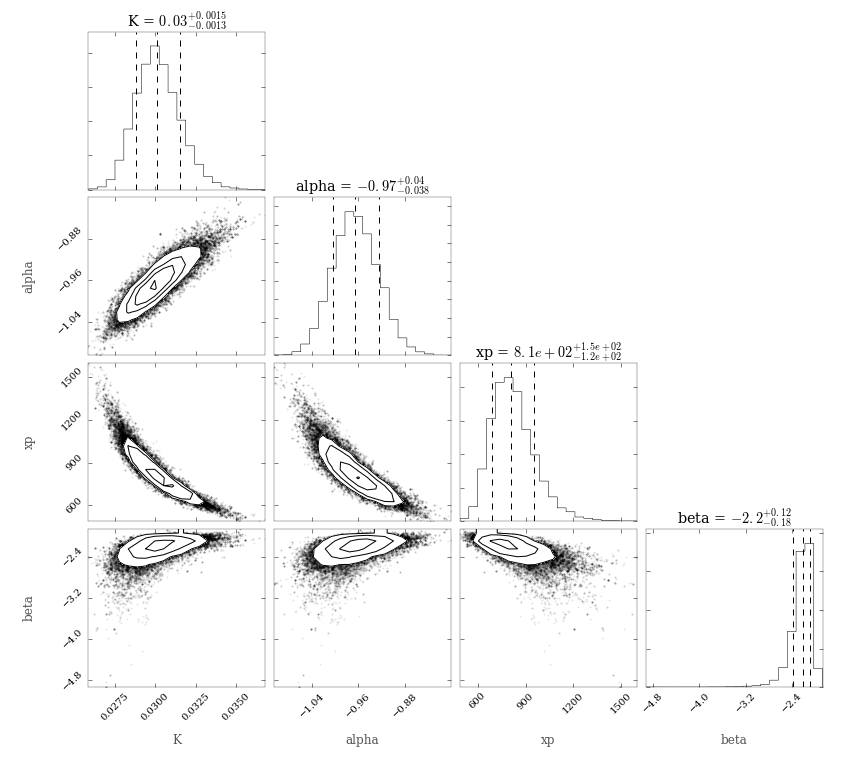

In [17]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

### Sample with Nested Sampling (MULTINEST)

(see parallel demo for tips on parallel sampling with MPI)

In [18]:
samples = bayes.sample_multinest(n_live_points=400,resume=False)


Sampling...

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt


<IPython.core.display.Javascript object>


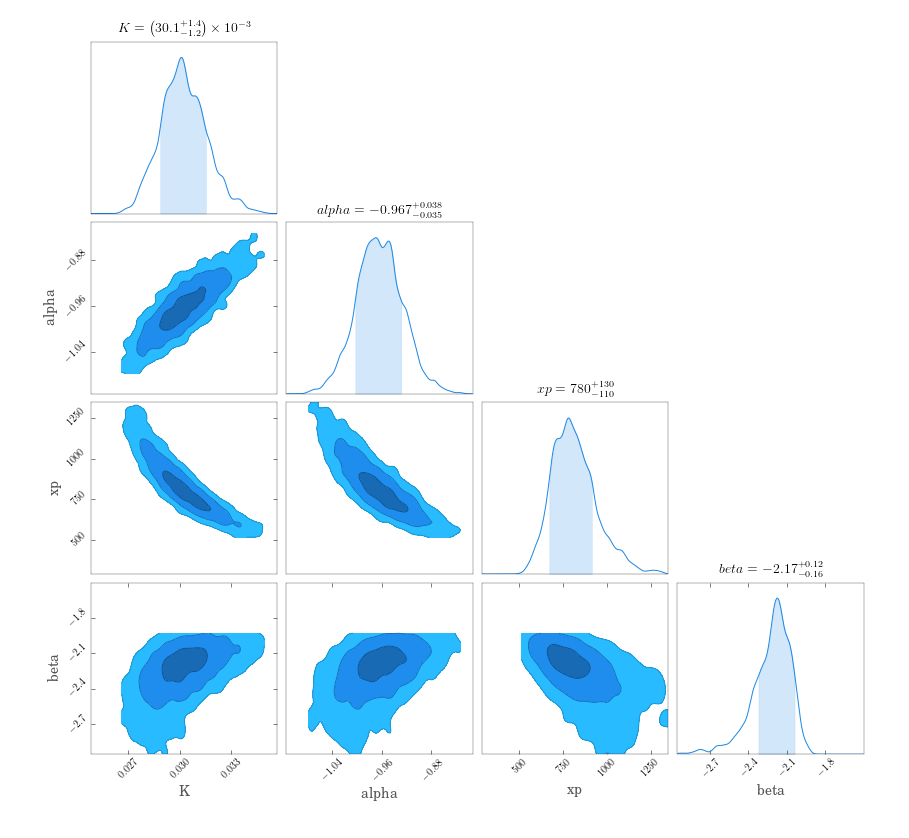

In [19]:
fig = bayes.corner_plot_cc()

#### Credible Regions

In [24]:
# equal-tailed credible regions
eq_tail = bayes.get_credible_intervals()


Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.659 -0.031 +0.035,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.930 -0.012 +0.013,
bn080916009.spectrum.main.Band.xp,(8.6 -0.4 +0.4)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.04 +0.032,



(probability 68)


In [25]:
# highest denisty intervals
hdi = bayes.get_highest_density_interval()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.66 -0.14 +0.14,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.93 -0.05 +0.05,
bn080916009.spectrum.main.Band.xp,(8.6 -1.5 +2.0)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.16 +0.12,


#### Effective free parameters (experimental)

Determine the complexity of your model and data 


In [26]:
bayes.get_effective_free_parameters()

3.9579152588503348

# PHA Exporting

While 3ML provides all the functionality needed to analyze data, it is often needed to double check results with other tools such as XSPEC. Since Fermi GBM files cannot be read into XSPEC, we provide a method export selections to a PHA file for single or multiple binnings.


### Single writeout

Any OGIP plugin has support for writing out a PHA and BAK file


In [7]:
nai3.write_pha('nai3',overwrite=True)

### Write PHA using the binning options

As shown above, we can store binning for the TTE light curve for viewing, time-resolved analysis, etc. but we can also exploit the binner to write out PHAII files with multiple selections


In [9]:
# Create the time bins
nai3.create_time_bins(0,10,method='constant',dt=1)

# Write them to a PHA file
nai3.write_pha_from_binner('nai3_binner',overwrite=True)



Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


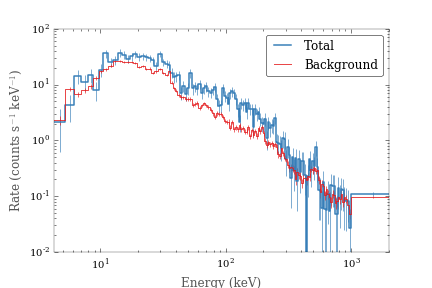

In [10]:
saved_pha = OGIPLike('test',pha_file='nai3_binner.pha{1}')

saved_pha.view_count_spectrum()